In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
folder_dataset = 'data/original'

In [3]:
files = [file for file in os.listdir(folder_dataset) if file.endswith('.jpg')]
len(files)

236

In [4]:
def process_image(img_name, show_process=False):
    # Load image
    img = cv.imread(os.path.join(folder_dataset, img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Preprocess
    smoothed = cv.blur(img,(5,5))
    denoise = cv.fastNlMeansDenoising(smoothed,None,21,7)
    # Convert to gray
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # CLAHE
    clahe_filter = cv.createCLAHE(clipLimit=3,tileGridSize=(7,7))
    clahe = clahe_filter.apply(img_gray)
    # Otsu
    _, otsu = cv.threshold(clahe,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    # Closing (Dilate+Erode)
    kernel = np.ones((37,37),np.uint8)
    closing = cv.morphologyEx(otsu, cv.MORPH_OPEN, kernel)
    # Fill holes    
    holes = closing.copy()
    contours,_ = cv.findContours(holes,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv.contourArea(contour)
        if area<5000:
            cv.drawContours(holes,[contour],0,0, thickness=cv.FILLED)
    if show_process:
        fig, axs = plt.subplots(1,6, figsize=(20,5))    
        axs[0].imshow(img)
        axs[0].axis('off')
        axs[0].set_title('(a) Original')
        axs[1].imshow(denoise)
        axs[1].axis('off')
        axs[1].set_title('(b) Preprocess')
        axs[2].imshow(clahe, cmap='gray')
        axs[2].axis('off')
        axs[2].set_title('(c) Gray and CLAHE')
        axs[3].imshow(otsu, cmap='gray')
        axs[3].axis('off')
        axs[3].set_title('(d) Otsu')
        axs[4].imshow(closing, cmap='gray')
        axs[4].axis('off')
        axs[4].set_title('(e) Closing')
        axs[5].imshow(holes, cmap='gray')
        axs[5].axis('off')
        axs[5].set_title('(f) Fill holes')
        plt.show()
    return holes

In [5]:
def percentage_white_pixels(image, height):
    img_cut1 = image[0:height,:]
    total_pixels_section = img_cut1.shape[0]*img_cut1.shape[1]
    pwp1 = (np.count_nonzero(img_cut1 == 255)*100)/total_pixels_section
    
    img_cut2 = image[height:image.shape[0]-1,:]
    total_pixels_section = img_cut2.shape[0]*img_cut2.shape[1]
    pwp2 = (np.count_nonzero(img_cut2 == 255)*100)/total_pixels_section
    return [pwp1, pwp2]
    
def contour_feature(image):
    contours,_ = cv.findContours(image,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    biggest_contour = []
    biggest_area = 0
    for contour in contours:
        area = cv.contourArea(contour)
        if area>biggest_area:
            biggest_contour = contour
            biggest_area = area
    if biggest_area>0:
        #cv.drawContours(img, biggest_contour, -1, (0, 255, 0), 3)
        rows,cols = img.shape[:2]
        [vx,vy,x,y] = cv.fitLine(biggest_contour, cv.DIST_L2,0,0.01,0.01)
        m = (float(vy)/vx)[0]
        n = y- m*x
        # Draw line
        lefty = int((-x*vy/vx) + y)
        righty = int(((cols-x)*vy/vx)+y)
        cv.line(img,(cols-1,righty),(0,lefty),(0,255,0),2)
        center_x = img.shape[1]/2
        center_y = m*center_x + n
        cv.circle(img, (int(center_x),int(center_y)), radius=3, color=(255, 0, 0), thickness=-1)
        cv.line(img,(cols-1,center_y),(0,center_y),(255,0,0),2)
        if center_y>1 and center_y<(rows-1):
            pwp1, pwp2 = percentage_white_pixels(image, int(center_y))
            if pwp1>pwp2:
                return [m,pwp1,pwp2, img]
            else:
                return [m,pwp2,pwp1, img]
        return [None, None, None, img]
    return [None, None, None, img]

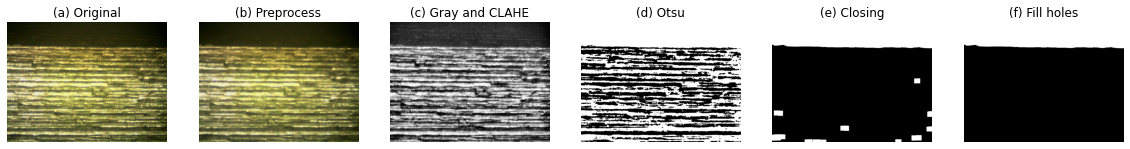

0.015052042 99.61538461538461 0.8952675065445026


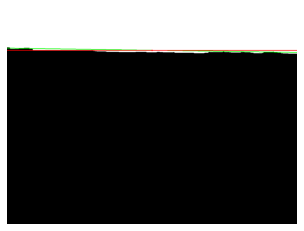

In [6]:
img_process = process_image(files[1], True)
m, pwp1, pwp2, img_contour =  contour_feature(img_process)  
print(m, pwp1, pwp2)
plt.imshow(img_contour)
plt.axis('off')
plt.show()

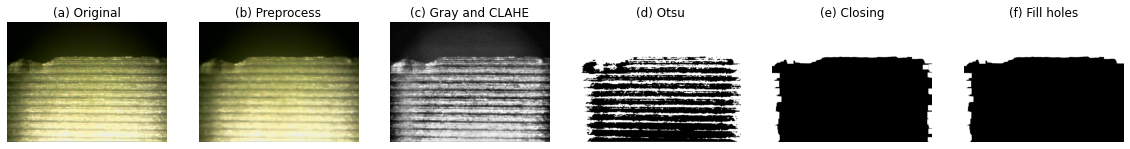

-0.03163846 97.43405720338983 5.035768072289157


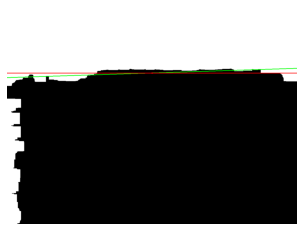

In [7]:
img_process = process_image(files[100], True)
m, pwp1, pwp2, img_contour =  contour_feature(img_process)  
print(m, pwp1, pwp2)
plt.imshow(img_contour)
plt.axis('off')
plt.show()

In [8]:
data = pd.DataFrame(columns=['img_name', 'folder','image', 'm', 'pwp1', 'pwp2'])
for file in files:
    img_process = process_image(file)
    m, pwp1, pwp2, img_contour =  contour_feature(img_process) 
    data = data.append({'img_name': file[:-4],'folder': int(file[6:8]), 'image': int(file[13:-4]), 'm':m, 'pwp1':pwp1, 'pwp2':pwp2}, ignore_index=True)
data.head()

,img_name,folder,image,m,pwp1,pwp2
0,Pieza_01_foto0,1,0,0.014250,99.488202,0.660530
1,Pieza_01_foto00,1,0,0.015052,99.615385,0.895268
2,Pieza_01_foto0118,1,118,0.007899,99.993265,0.860342
3,Pieza_01_foto0119,1,119,0.004415,100.000000,0.820312
4,Pieza_01_foto0138,1,138,0.020510,98.992797,1.093524


In [9]:
data_category = pd.read_csv('data/info_category.csv', delimiter=';', decimal=".")
data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
data.to_csv('data/data_category.csv', index=False, sep=';', decimal=".")

In [10]:
data = pd.read_csv('data/data_category.csv', delimiter=';', decimal=".")

In [11]:
data

,img_name,folder,image,category,m,pwp1,pwp2
0,Pieza_01_foto0,1,0,2,0.014250,99.488202,0.660530
1,Pieza_01_foto39,1,39,2,0.008234,99.884938,1.733670
2,Pieza_01_foto76,1,76,2,0.014032,99.734859,0.645357
3,Pieza_01_foto118,1,118,1,0.009337,99.950960,0.809796
4,Pieza_01_foto119,1,119,1,0.003699,100.000000,0.466821
...,...,...,...,...,...,...,...
231,Pieza_13_foto173,13,173,2,0.008122,99.293119,1.241158
232,Pieza_13_foto232,13,232,2,0.004124,99.971626,0.924307
233,Pieza_13_foto233,13,233,2,0.005626,99.707126,2.012965
234,Pieza_13_foto243,13,243,2,-0.003536,99.223019,2.103234


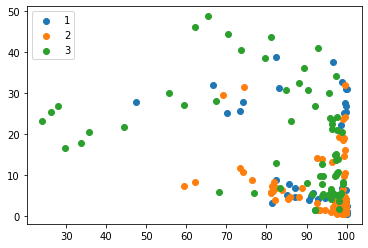

In [19]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp1"], data_category.loc[:,"pwp2"], label=type_label)
    plt.legend()

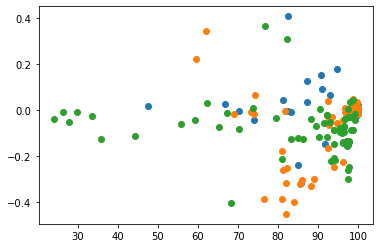

In [17]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp1"], data_category.loc[:,"m"], label=type_label)

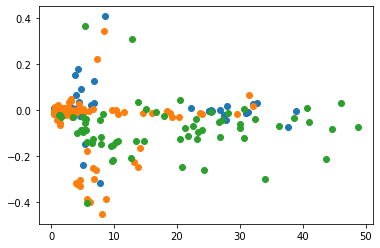

In [18]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp2"], data_category.loc[:,"m"], label=type_label)